# Capstone Project

## Import Semua Packages/Library yang Digunakan

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
import seaborn as sns

## Data Preparation

### Data Loading

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d fedesoriano/stroke-prediction-dataset
!unzip stroke-prediction-dataset.zip

Dataset URL: https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset
License(s): copyright-authors
  0% 0.00/67.4k [00:00<?, ?B/s]
100% 67.4k/67.4k [00:00<00:00, 253MB/s]
Archive:  stroke-prediction-dataset.zip
  inflating: healthcare-dataset-stroke-data.csv  


In [ ]:
df = pd.read_csv('healthcare-dataset-stroke-data.csv')
df

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


### Exploratory Data Analysis

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [ ]:
df.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


### Handling Missing Value

In [ ]:
df.isna().sum()

,0
id,0
gender,0
age,0
hypertension,0
heart_disease,0
ever_married,0
work_type,0
Residence_type,0
avg_glucose_level,0
bmi,201


### Handling Outliers

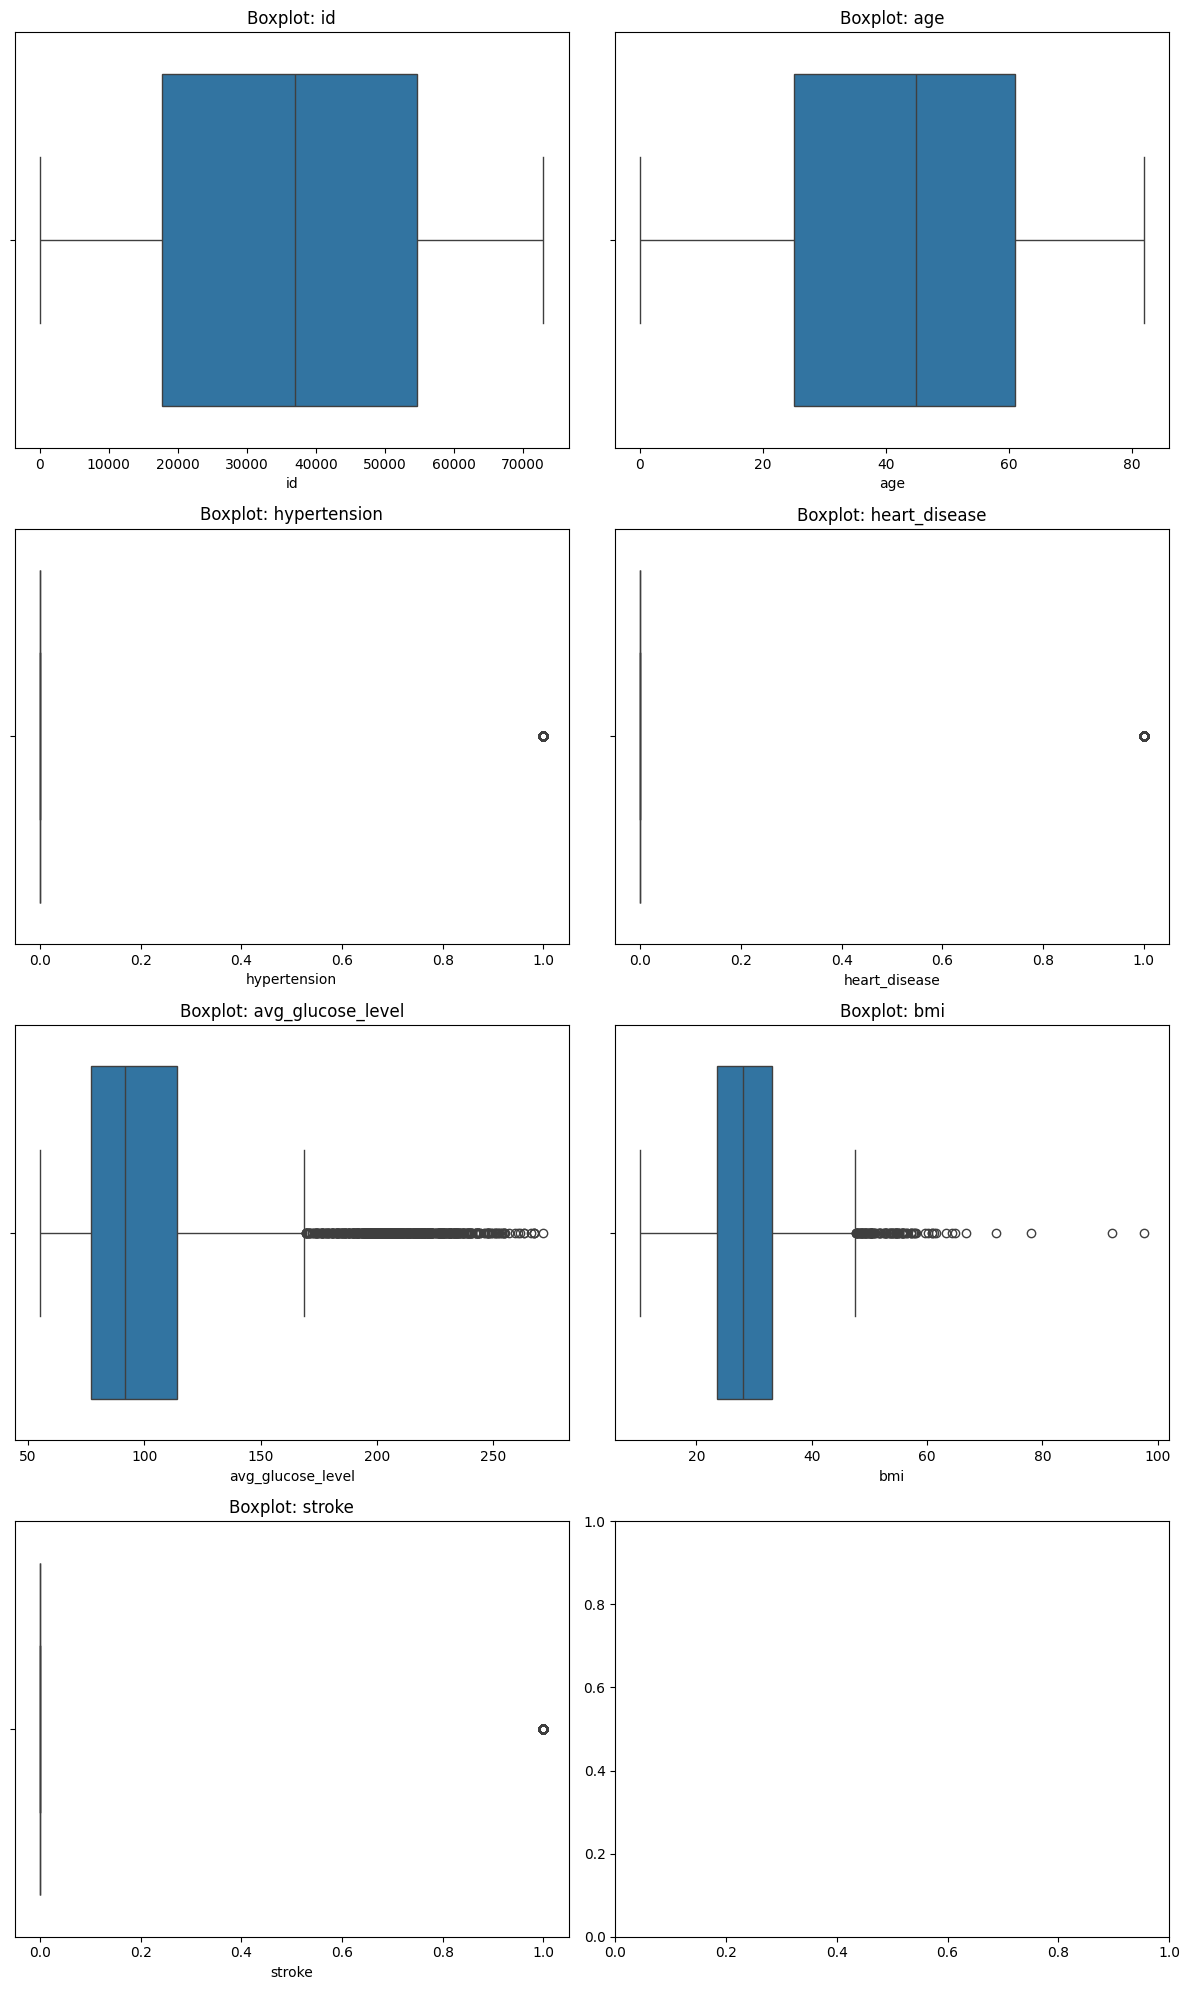

In [ ]:
numeric_cols = df.select_dtypes(include='number').columns

num_cols = 2
num_rows = (len(numeric_cols) + num_cols - 1) // num_cols

fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(12, 5 * num_rows))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    sns.boxplot(x=df[col], ax=axes[i])
    axes[i].set_title(f'Boxplot: {col}')
    axes[i].set_xlabel(col)

plt.tight_layout()
plt.show()

In [ ]:
# Hitung Q1, Q3, dan IQR hanya untuk kolom numerikal
Q1 = df[numeric_cols].quantile(0.25)
Q3 = df[numeric_cols].quantile(0.75)
IQR = Q3 - Q1
# Buat filter untuk menghapus baris yang mengandung outlier di kolom numerikal
filter_outliers = ~((df[numeric_cols] < (Q1 - 1.5 * IQR)) |
                    (df[numeric_cols] > (Q3 + 1.5 * IQR))).any(axis=1)
# Terapkan filter ke dataset asli (termasuk kolom non-numerikal)
df = df[filter_outliers]
# Cek ukuran dataset setelah outlier dihapus
df.shape

(3824, 12)

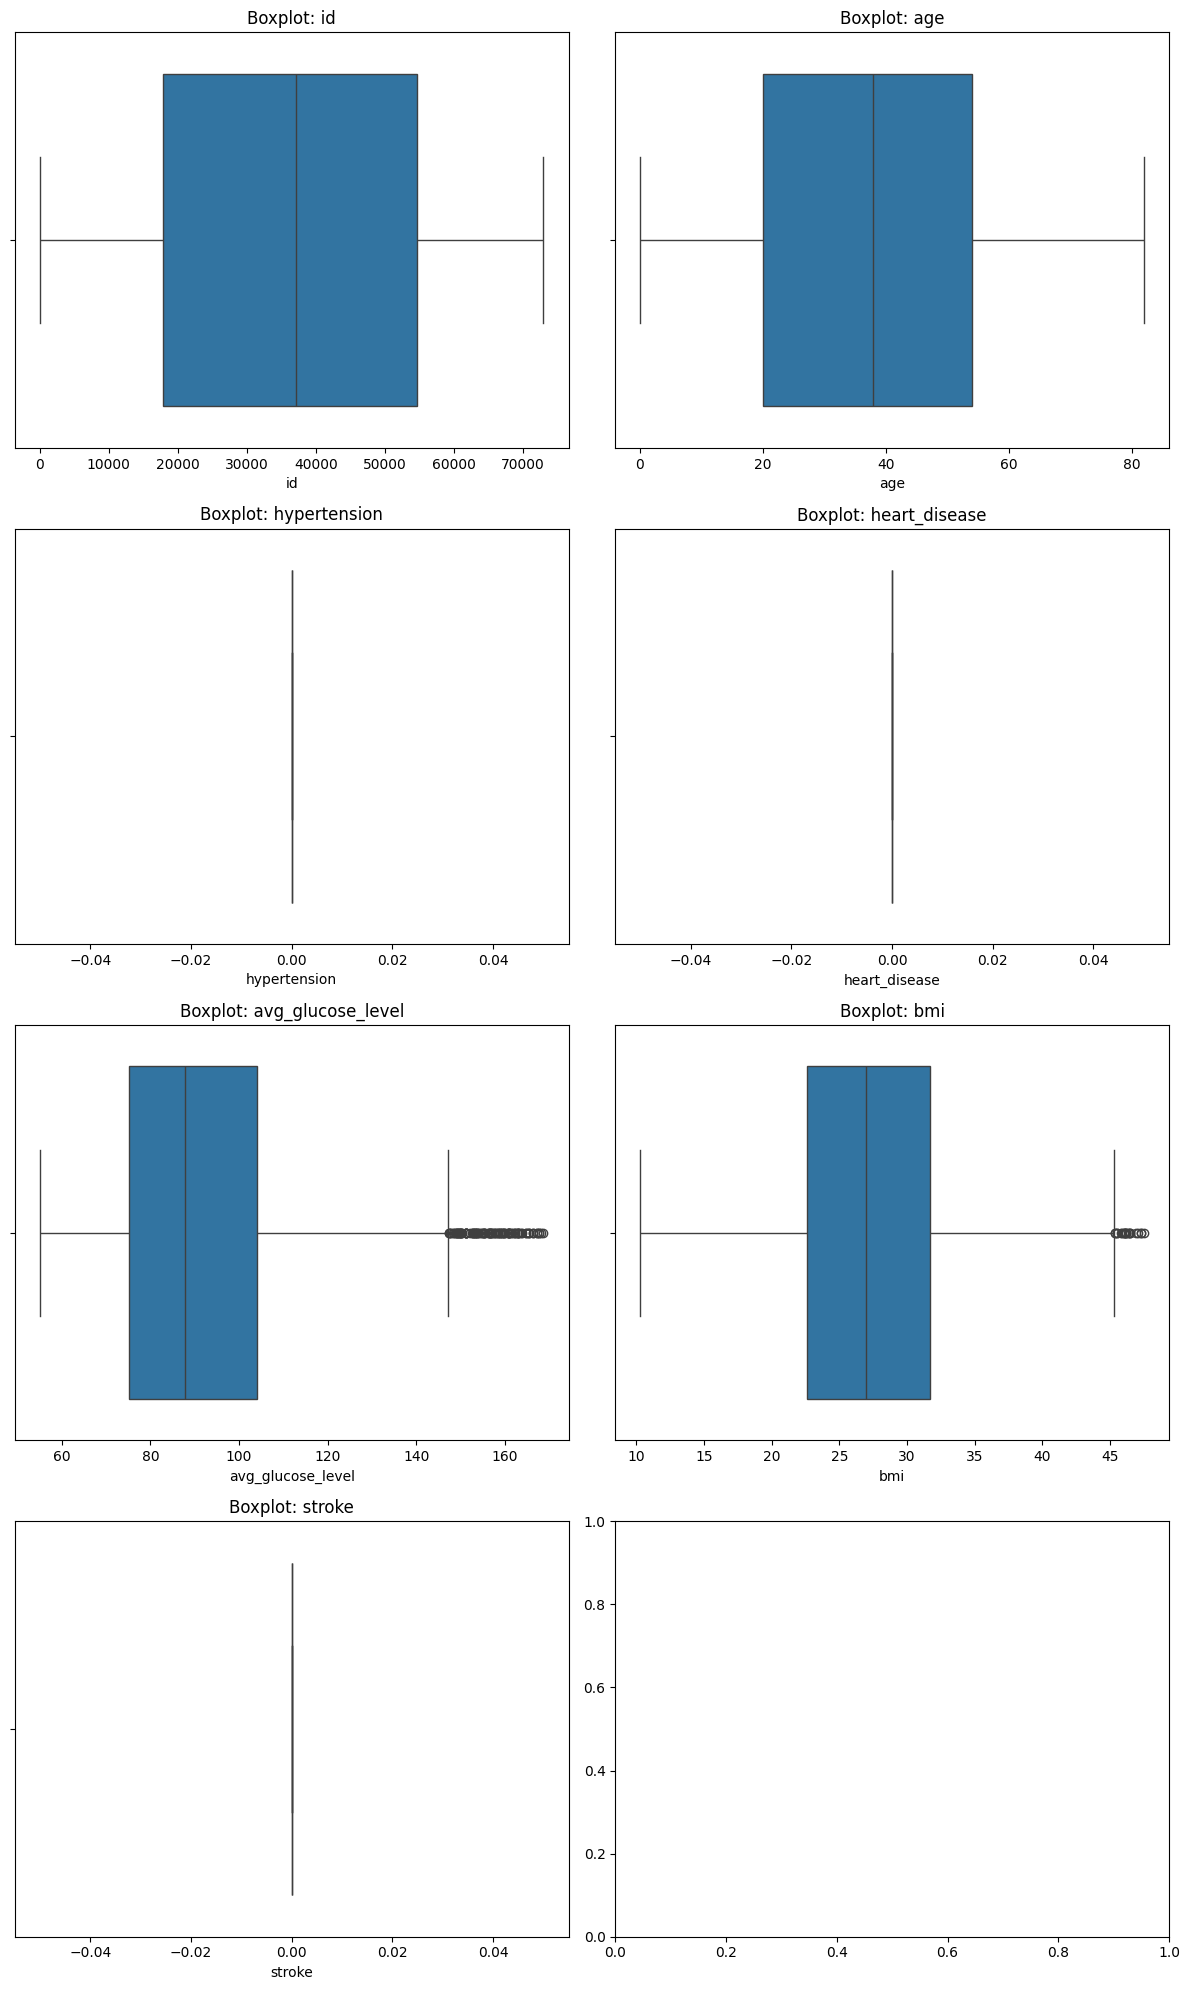

In [ ]:
numeric_cols = df.select_dtypes(include='number').columns

num_cols = 2
num_rows = (len(numeric_cols) + num_cols - 1) // num_cols

fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(12, 5 * num_rows))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    sns.boxplot(x=df[col], ax=axes[i])
    axes[i].set_title(f'Boxplot: {col}')
    axes[i].set_xlabel(col)

plt.tight_layout()
plt.show()

### Exploratory Data Analysis

#### Univariate Analysis

In [ ]:
numerical_features = df.select_dtypes(include='number').columns
categorical_features = df.select_dtypes(include='object').columns.to_list()

In [ ]:
print(categorical_features)
print(numerical_features)

['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
Index(['id', 'age', 'hypertension', 'heart_disease', 'avg_glucose_level',
       'bmi', 'stroke'],
      dtype='object')


In [ ]:
print(df['age'])

249      3.0
251      8.0
252     70.0
253     14.0
255     52.0
        ... 
5104    13.0
5106    81.0
5107    35.0
5108    51.0
5109    44.0
Name: age, Length: 3824, dtype: float64



Univariate summary for 'gender':
        jumlah sampel  persentase
gender                           
Female           2300        60.1
Male             1523        39.8
Other               1         0.0


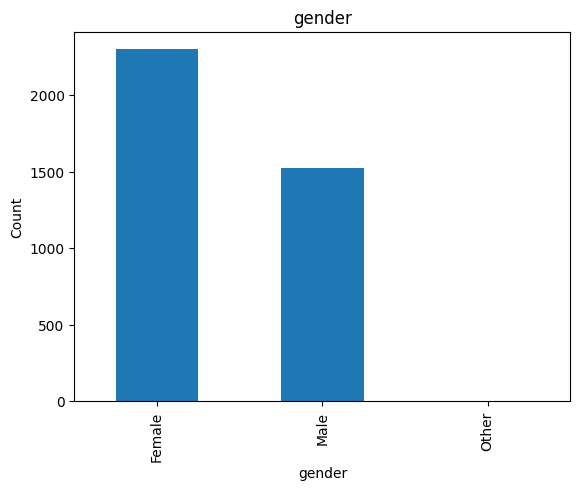


Univariate summary for 'ever_married':
              jumlah sampel  persentase
ever_married                           
Yes                    2234        58.4
No                     1590        41.6


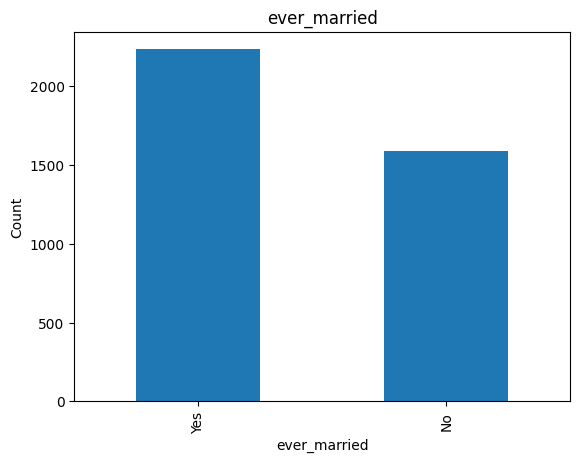


Univariate summary for 'work_type':
               jumlah sampel  persentase
work_type                               
Private                 2165        56.6
children                 672        17.6
Self-employed            495        12.9
Govt_job                 470        12.3
Never_worked              22         0.6


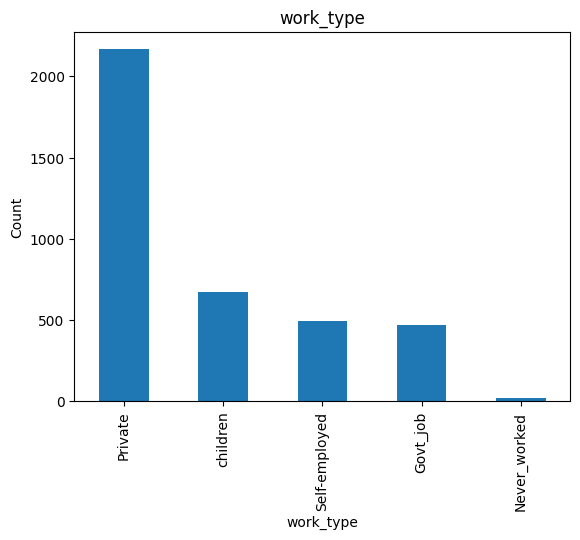


Univariate summary for 'Residence_type':
                jumlah sampel  persentase
Residence_type                           
Urban                    1943        50.8
Rural                    1881        49.2


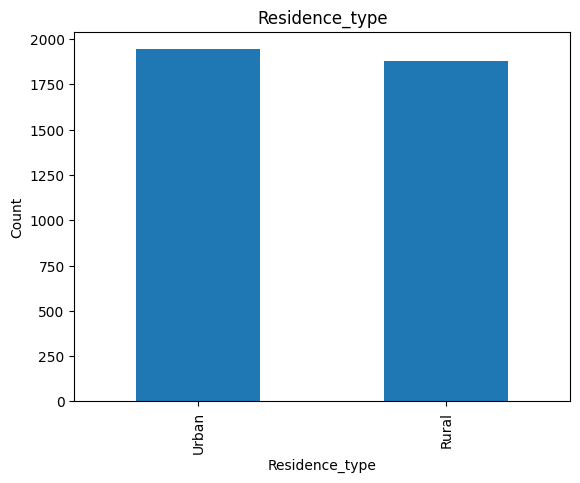


Univariate summary for 'smoking_status':
                 jumlah sampel  persentase
smoking_status                            
never smoked              1367        35.7
Unknown                   1332        34.8
formerly smoked            572        15.0
smokes                     553        14.5


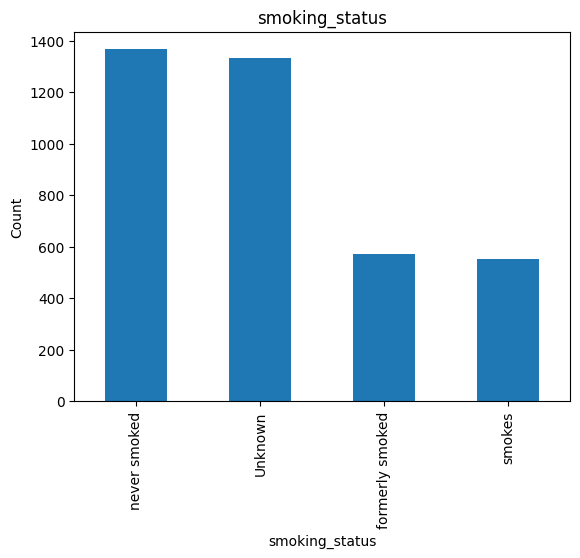

In [ ]:
for feature in categorical_features:
    count = df[feature].value_counts()
    percent = 100 * df[feature].value_counts(normalize=True)

    summary_df = pd.DataFrame({
        'jumlah sampel': count,
        'persentase': percent.round(1)
    })
    print(f"\nUnivariate summary for '{feature}':")
    print(summary_df)

    count.plot(kind='bar', title=feature)
    plt.xlabel(feature)
    plt.ylabel("Count")
    plt.show()

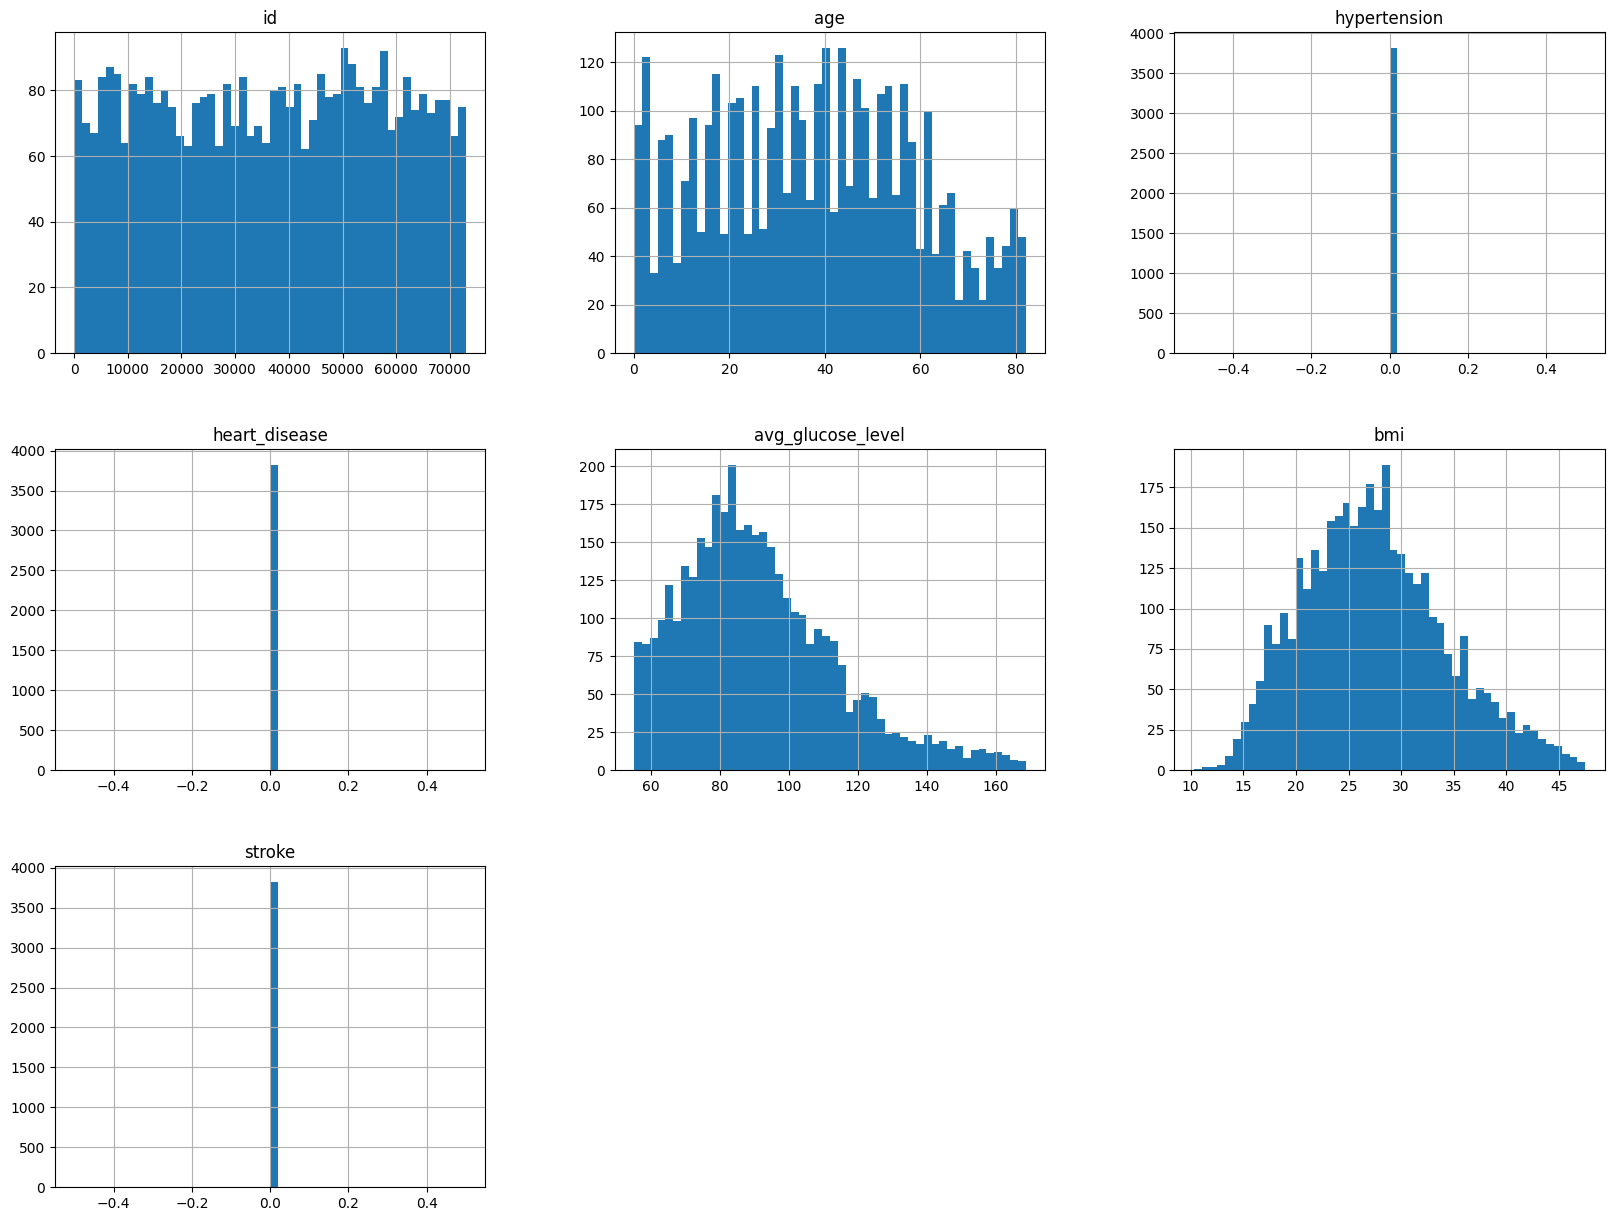

In [ ]:
df.hist(bins=50, figsize=(20,15))
plt.show()

#### Multivariate Analysis

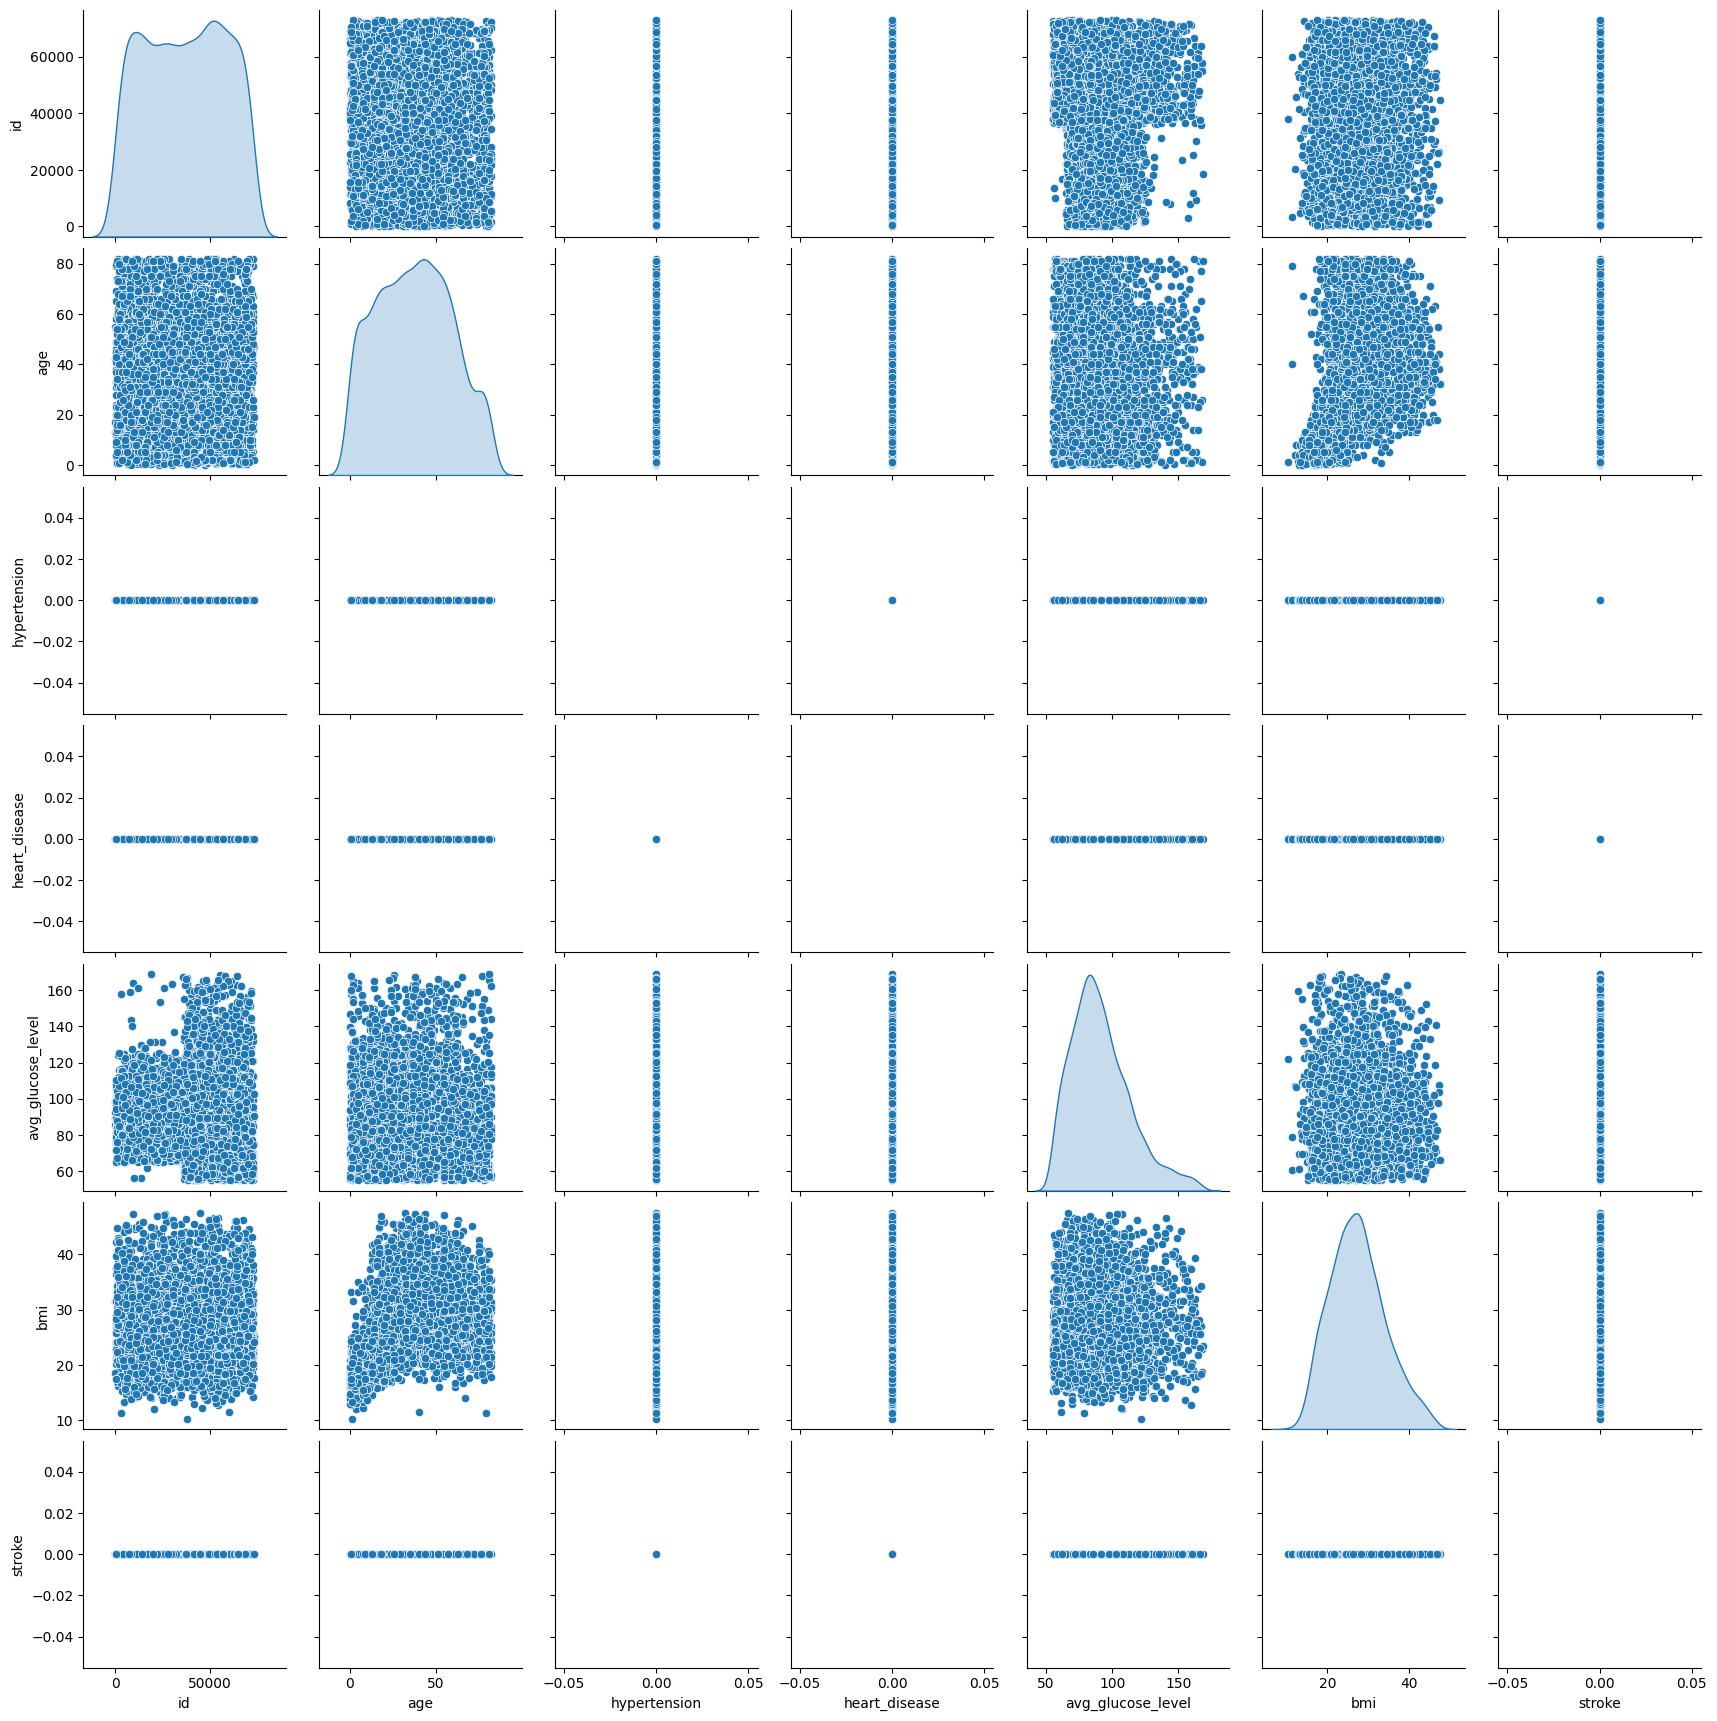

In [ ]:
sns.pairplot(df, diag_kind = 'kde')

Text(0.5, 1.0, 'Correlation Matrix untuk Fitur Numerik ')

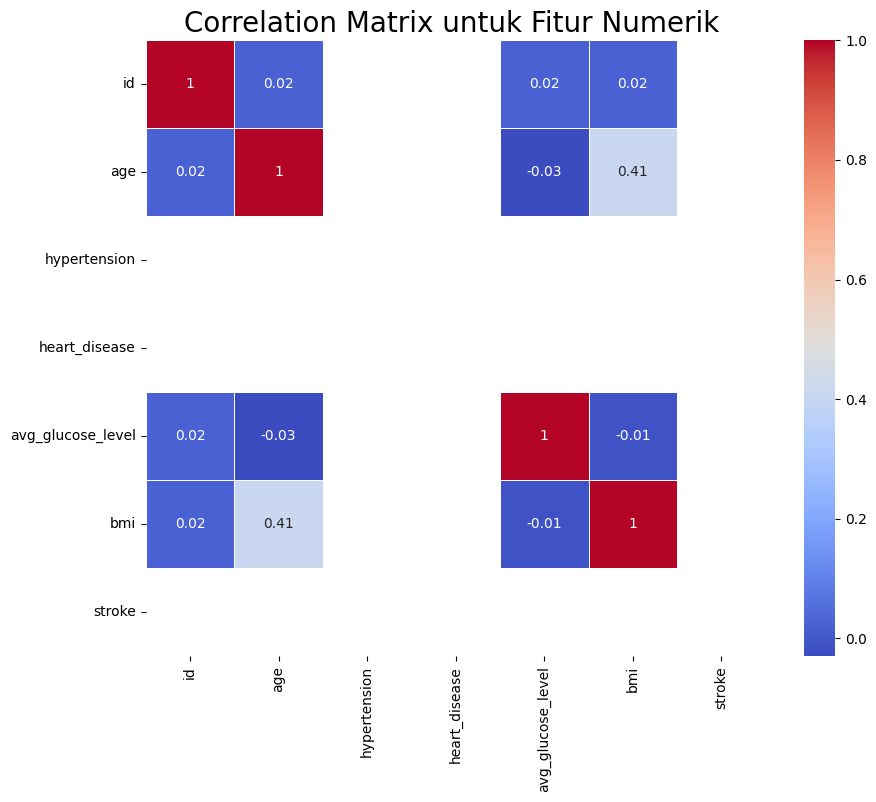

In [ ]:
plt.figure(figsize=(10, 8))
correlation_matrix = df[numerical_features].corr().round(2)

# Untuk menge-print nilai di dalam kotak, gunakan parameter anot=True
sns.heatmap(data=correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, )
plt.title("Correlation Matrix untuk Fitur Numerik ", size=20)